# Load and Clean data

In [1]:
from functions import *
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 137
test_fraction = 0.2
print('Loading and EDA')
df,target,df_info = EDA('../input/train.csv')

Loading and EDA
version 5


# Split data into training and test set and Set up benchmark model

In [2]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size= test_fraction, random_state=RANDOM_SEED)
base_model = RandomForestRegressor(random_state = RANDOM_SEED)
base_model.fit(X_train,y_train)
evaluate(base_model, X_test, y_test)

Model Performance
R2 Score: 0.26% degrees.
RMSE = 1.4671


(0.2555468339838146, 1.4670976524971435)

# Implement Random Forest Regression Model

In [3]:
best_params_ = {'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}
 
rf_best = RandomForestRegressor(**best_params_,
                                n_jobs = 8, random_state = RANDOM_SEED)
rf_best.fit(X_train,y_train)
evaluate(rf_best, X_test, y_test)

Model Performance
R2 Score: 0.33% degrees.
RMSE = 1.3912


(0.3305878537298952, 1.3911921732133308)

# Implement XGB Model

In [4]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from permutation_features import permutation_features

In [5]:
p_features = permutation_features()
features = feature_sel(rf_best,X_train,y_train)

Index(['20aa07010', '22ed6dba3', '87ffda550', '251d1aa17', '963a49cdc',
       'a75d400b8', '68a945b18', '63c094ba4', '342e7eb03', '4da206d28',
       ...
       'a3fb07bfd', 'b8f892930', 'e79e5f72c', 'a396ceeb9', '4dcf81d65',
       '8781e4b91', 'ef30f6be5', '6df033973', '23310aa6f', '5831f4c76'],
      dtype='object', length=277)


In [6]:
def run_xgb(X_train,y_train,X_test,y_test):
    xgb_grid_best = {
        "objective":'reg:squarederror',
        'colsample_bytree': 0.5,
        'gamma': 5,
        'learning_rate': 0.05,
        'max_depth': 10,
        'n_estimators': 177,
        'subsample': 0.8
    }
    xgb_fit_params = {
        'eval_metric': 'rmse',
        'early_stopping_rounds': 10,
        'verbose': False
    }
    xgb_para = dict()
    xgb_para['reg_params'] = xgb_grid_best
    xgb_para['fit_params'] = xgb_fit_params
    xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

    xgb_best = xgb.XGBRegressor(**xgb_grid_best)
    xgb_best.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    **xgb_fit_params)
    evaluate(xgb_best, X_test, y_test)
    return xgb_best

In [7]:
xgb_best = run_xgb(X_train[features],y_train,X_test[features],y_test)

Model Performance
R2 Score: 0.31% degrees.
RMSE = 1.4077


# LGB Model Implementation 

In [8]:
def run_lgb(X_train,y_train,X_test,y_test):
    dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 137)
    lgb_params_best = {
        #"objective":'reg:squarederror',
        "objective" : "regression",
        "metric" : "rmse",
        'learning_rate': np.arange(0.001, 0.1, 0.01)[8],
        'max_depth': np.arange(1, 20, 1, dtype=int)[17],
        'min_child_weight': np.arange(1, 8, 1, dtype=int)[5],
        'colsample_bytree': np.arange(0.4, 0.8, 0.1)[1],
        'subsample': 0.8649004443092452,
        #'n_estimators':     100
    }
    lgtrain = lgb.Dataset(dev_X, label=dev_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(lgb_params_best, lgtrain, 5000,
                  valid_sets=[lgtrain, lgval], 
                  early_stopping_rounds=150, 
                  verbose_eval=150, 
                  evals_result=evals_result)
    return model

In [9]:
lgb_best = run_lgb(X_train[features],y_train,X_test[features],y_test)
lgb_pred = lgb_best.predict(X_test[features], num_iteration=lgb_best.best_iteration)

Training until validation scores don't improve for 150 rounds
[150]	training's rmse: 0.799426	valid_1's rmse: 1.37573
Early stopping, best iteration is:
[75]	training's rmse: 0.980108	valid_1's rmse: 1.36492


In [10]:
loss_func = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
loss_func(lgb_pred,y_test)

1.419762573724477

# Combine models to give final prediction

In [11]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
xgb_pred = xgb_best.predict(X_test[features])
rf_pred = rf_best.predict(X_test)
final_pred_t = 0.2 * xgb_pred + 0.6 * rf_pred + 0.2 * lgb_pred
loss = loss_func(final_pred_t, y_test)
loss 

1.3810009463856616

Model Performance
R2 Score: 0.27% degrees.
RMSE = 1.6002
Training until validation scores don't improve for 150 rounds
[150]	training's rmse: 0.561941	valid_1's rmse: 1.50243
Early stopping, best iteration is:
[47]	training's rmse: 0.908787	valid_1's rmse: 1.45974
Model Performance
R2 Score: 0.25% degrees.
RMSE = 1.3791
Training until validation scores don't improve for 150 rounds
[150]	training's rmse: 0.559481	valid_1's rmse: 1.52529
Early stopping, best iteration is:
[48]	training's rmse: 0.913748	valid_1's rmse: 1.51589
Model Performance
R2 Score: 0.30% degrees.
RMSE = 1.5614
Training until validation scores don't improve for 150 rounds
[150]	training's rmse: 0.534886	valid_1's rmse: 1.56954
Early stopping, best iteration is:
[46]	training's rmse: 0.890427	valid_1's rmse: 1.54256
Model Performance
R2 Score: 0.21% degrees.
RMSE = 1.3198
Training until validation scores don't improve for 150 rounds
[150]	training's rmse: 0.529334	valid_1's rmse: 1.65959
Early stopping, best iteration

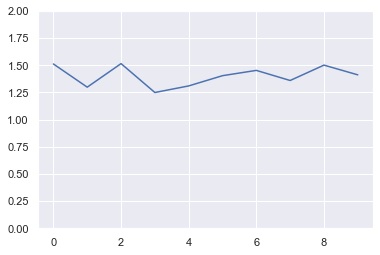

In [12]:
from tqdm import tqdm_notebook
def cross_validate(X,y,xgb,rf,lgb,features):
    loss = []
    loss_func = lambda y, pred: np.sqrt(mean_squared_error(y, pred))
    kf = KFold(n_splits=10, random_state=10, shuffle=False)
    for fold, (train_index, test_index) in tqdm_notebook(list(enumerate(list(kf.split(X))[:]))):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf_best.fit(X_train,y_train)
        xgb_best = run_xgb(X_train[features],y_train,X_test[features],y_test)
        lgb_best = run_lgb(X_train[features],y_train,X_test[features],y_test)
        xgb_pred = xgb.predict(X_test[features])
        rf_pred = rf.predict(X_test)
        lgb_pred = lgb.predict(X_test[features], num_iteration=lgb.best_iteration)
        final_pred = 0.2 * xgb_pred + 0.6 * rf_pred + 0.2 * lgb_pred
        loss.append(loss_func(final_pred, y_test))
    return loss
cv_final_results = cross_validate(X_test,y_test,xgb_best,rf_best,lgb_best,features)
sns.set(style='darkgrid')
plt.ylim(0, 2)
sns.lineplot(x=range(10), y=cv_final_results)
print('mean of rmse %f , std of rmse %f' % (np.mean(cv_final_results),np.std(cv_final_results)))

# Combine model prediction with data pattern

In [102]:
all_features = df.columns
test = pd.read_csv('../input/test.csv')
xgb_pred = xgb_best.predict(test[features])
rf_pred = rf_best.predict(test[all_features])
lgb_pred = lgb_best.predict(test[features], num_iteration=lgb_best.best_iteration)
final_pred = np.expm1(0.2 * xgb_pred + 0.6 * rf_pred + 0.2 * lgb_pred)
final_pred = pd.DataFrame(final_pred,index = test.ID)
final_pred = final_pred.reset_index()
final_pred.columns = ['ID','target']
final_pred.to_csv(r'../output/model_prediction_before_pattern.csv',index=False)